<a href="https://colab.research.google.com/github/mst-projects/numerai/blob/main/train_tensorflow_densenet_eraboost_2021_12_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to Google Drive

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import gc
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

import random as python_random

import warnings
warnings.simplefilter('ignore')

In [32]:
np.random.seed(1)
python_random.seed(1)
tf.random.set_seed(1)

In [33]:
# CONSTANTS:
TOURNAMENT_NAME = ""
TARGET_NAME = f"target{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction{TOURNAMENT_NAME}"

Read training data

In [34]:
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.50,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.50,1.00,0.50,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.50,0.50,0.75,0.50,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.50,0.25,0.25,0.75,0.50,1.00,0.50,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.50,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.50,0.50,0.50,0.50,0.25,0.25,0.50,0.00,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.50,0.25,0.75,0.50,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.00,0.25,1.00,0.50,1.00,1.00,0.50,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.50,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.50,0.50,1.00,0.50,0.50,0.50,0.25,0.00,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.50,0.50,0.75,0.50,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.50,1.00,0.00,1.00,1.00,0.50,1.00,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.00,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.00,0.50,0.50,0.00,1.00,0.00,0.75,0.00,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.50,0.50,0.50,0.50,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,0.75,1.00,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.50,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.00,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.00,0.50,0.50,0.25,0.00,0.50,0.00,0.50,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.50,0.50,0.50,0.50,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.50,1.00,0.50,0.75,0.25,0.50,0.00,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.50,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501803,nff6a8a8feaeeb52,era120,train,0.50,0.50,0.25,0.00,0.00,0.50,0.75,0.00,0.75,0.75,0.25,0.00,1.00,0.00,0.75,0.00,0.50,1.00,0.25,0.25,0.00,0.50,0.75,0.

Define function for plotting loss curve

In [35]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min() * 0.95, mse.max() * 1.03])
    plt.draw()

Define functions for validation

In [38]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def sharpe(x):
    return np.mean(x)/np.std(x, ddof=1)

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def sortino_ratio(x, target=0.010415154):
   xt = x# - target
   return np.mean(xt) / (np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5

def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]

Build model

In [37]:
def build_model(learning_rate, layer_size1, layer_size2):
    model = keras.Sequential([
      layers.Dense(layer_size1, activation='relu',input_shape=[len(feature_names)]),
      layers.Dense(layer_size2, activation='relu'
                   , kernel_regularizer=tf.keras.regularizers.l2(0.01)
                  ),
      layers.Dense(1, activation=('sigmoid'))
                   ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    return model

Define training model function

In [39]:
def train_model(model, feature, label, epochs, batch_size):
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="log_dir", histogram_freq=1)
    # early_stopping_callback = tf.keras.callbacks.EalryStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    # baseline=None, restore_best_weights=False)
    history = model.fit(x=feature,
                        y=label,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        # callbacks=[tensorboard_callback]
                       )
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mse"]
    
    return epochs, mse

In [40]:
# Define features
feature_names = [
    f for f in training_data.columns if f.startswith("feature")]

# Set features and target for training
train_features = training_data[feature_names]
train_target = training_data[TARGET_NAME]

# Set Parameters:
lr = 0.0001
# epochs = 10
batch_size = 1024
layer_Size1 = 32
layer_Size2 = 32

Build model

In [41]:
model = build_model(learning_rate=lr, layer_size1=layer_Size1, layer_size2=layer_Size2)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                9952      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,041
Trainable params: 11,041
Non-trainable params: 0
_________________________________________________________________


train

---------------
iteration 0
worst eras:  ['era119', 'era107', 'era68', 'era91', 'era59', 'era85', 'era103', 'era58', 'era112', 'era49', 'era113', 'era60', 'era21', 'era69', 'era34', 'era25', 'era27', 'era80', 'era110', 'era53', 'era100', 'era28', 'era40', 'era19', 'era73', 'era114', 'era106', 'era117', 'era81', 'era54', 'era14', 'era74', 'era41', 'era9', 'era52', 'era66', 'era7', 'era79', 'era50', 'era109', 'era62', 'era94', 'era89', 'era46', 'era97', 'era57', 'era3', 'era118', 'era101', 'era4', 'era84', 'era33', 'era65', 'era35', 'era32', 'era47', 'era75', 'era82', 'era67', 'era45']

performance over time


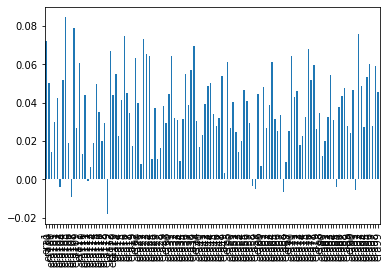


autocorrelation:  -0.01707142992330874
mean correlation:  0.03537135095433987
sharpe:  1.6546472086227388
smart sharpe:  1.6758734628949468
1.6758734628949468
---------------
iteration 1
worst eras:  ['era119', 'era85', 'era91', 'era103', 'era112', 'era68', 'era107', 'era58', 'era49', 'era34', 'era21', 'era59', 'era27', 'era69', 'era60', 'era100', 'era113', 'era114', 'era25', 'era73', 'era109', 'era9', 'era53', 'era28', 'era19', 'era14', 'era40', 'era110', 'era117', 'era106', 'era80', 'era94', 'era54', 'era71', 'era79', 'era81', 'era18', 'era89', 'era3', 'era52', 'era97', 'era47', 'era4', 'era67', 'era57', 'era33', 'era41', 'era74', 'era35', 'era7', 'era46', 'era102', 'era118', 'era45', 'era20', 'era65', 'era56', 'era42', 'era66', 'era86']

performance over time


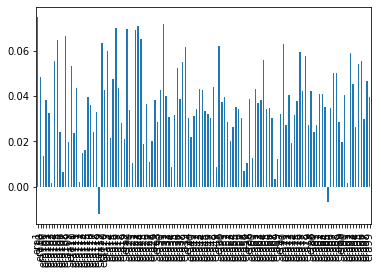


autocorrelation:  0.00559130586829772
mean correlation:  0.03558676466401724
sharpe:  1.9710287030680191
smart sharpe:  1.9519457578733386
1.9519457578733386
---------------
iteration 2
worst eras:  ['era119', 'era85', 'era112', 'era49', 'era107', 'era68', 'era103', 'era91', 'era27', 'era59', 'era21', 'era58', 'era60', 'era34', 'era100', 'era25', 'era14', 'era40', 'era114', 'era69', 'era53', 'era9', 'era110', 'era113', 'era81', 'era71', 'era73', 'era109', 'era28', 'era18', 'era19', 'era118', 'era67', 'era79', 'era106', 'era3', 'era80', 'era86', 'era94', 'era33', 'era117', 'era74', 'era54', 'era65', 'era4', 'era47', 'era41', 'era37', 'era90', 'era57', 'era26', 'era89', 'era7', 'era35', 'era50', 'era84', 'era52', 'era83', 'era42', 'era66']

performance over time


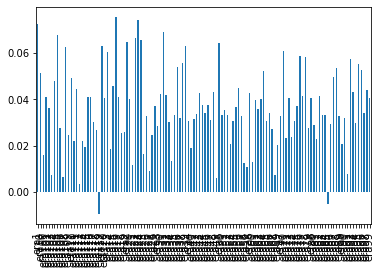


autocorrelation:  0.011087713484435144
mean correlation:  0.0359786015767776
sharpe:  2.0938455864689622
smart sharpe:  2.0623012966828735
2.0623012966828735
---------------
iteration 3
worst eras:  ['era119', 'era85', 'era34', 'era107', 'era21', 'era91', 'era114', 'era112', 'era28', 'era59', 'era68', 'era100', 'era27', 'era103', 'era25', 'era49', 'era19', 'era69', 'era58', 'era35', 'era109', 'era113', 'era14', 'era53', 'era9', 'era3', 'era4', 'era80', 'era20', 'era81', 'era94', 'era110', 'era51', 'era117', 'era77', 'era106', 'era97', 'era54', 'era52', 'era73', 'era60', 'era29', 'era79', 'era47', 'era99', 'era116', 'era45', 'era56', 'era57', 'era89', 'era71', 'era62', 'era46', 'era33', 'era40', 'era30', 'era101', 'era74', 'era63', 'era55']

performance over time


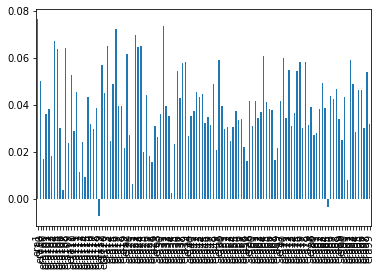


autocorrelation:  -0.048323365684266734
mean correlation:  0.03780809693599284
sharpe:  2.2851639564286264
smart sharpe:  2.3874150423984353
2.3874150423984353
---------------
iteration 4
worst eras:  ['era119', 'era68', 'era85', 'era49', 'era112', 'era60', 'era103', 'era107', 'era34', 'era118', 'era21', 'era91', 'era27', 'era114', 'era67', 'era18', 'era58', 'era59', 'era86', 'era100', 'era71', 'era79', 'era110', 'era28', 'era25', 'era74', 'era41', 'era94', 'era40', 'era3', 'era33', 'era75', 'era84', 'era35', 'era26', 'era17', 'era37', 'era83', 'era51', 'era9', 'era42', 'era8', 'era66', 'era81', 'era69', 'era19', 'era44', 'era11', 'era65', 'era73', 'era102', 'era14', 'era50', 'era117', 'era7', 'era109', 'era53', 'era106', 'era97', 'era29']

performance over time


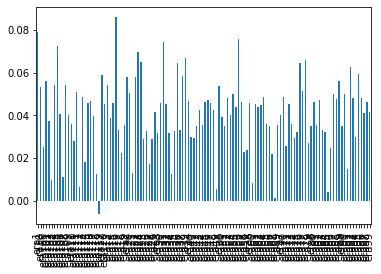


autocorrelation:  0.052077822453563995
mean correlation:  0.04039663857380727
sharpe:  2.3888735366853653
smart sharpe:  2.259058601908882
2.259058601908882
---------------
iteration 5
worst eras:  ['era85', 'era34', 'era114', 'era21', 'era91', 'era107', 'era3', 'era80', 'era119', 'era100', 'era116', 'era56', 'era54', 'era112', 'era89', 'era99', 'era35', 'era27', 'era59', 'era113', 'era69', 'era68', 'era103', 'era28', 'era45', 'era58', 'era25', 'era87', 'era55', 'era77', 'era41', 'era82', 'era43', 'era94', 'era46', 'era74', 'era20', 'era4', 'era30', 'era32', 'era19', 'era79', 'era81', 'era62', 'era9', 'era57', 'era97', 'era47', 'era14', 'era6', 'era51', 'era84', 'era49', 'era117', 'era63', 'era42', 'era29', 'era53', 'era101', 'era106']

performance over time


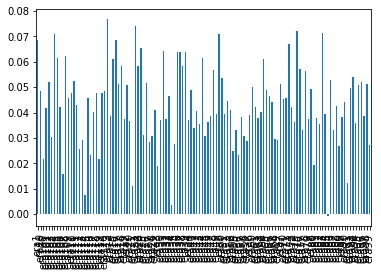


autocorrelation:  0.037810549719608386
mean correlation:  0.04302607257005854
sharpe:  2.8040416606586573
smart sharpe:  2.689525426791113
2.689525426791113
---------------
iteration 6
worst eras:  ['era60', 'era68', 'era119', 'era67', 'era85', 'era49', 'era118', 'era91', 'era107', 'era21', 'era103', 'era112', 'era86', 'era34', 'era33', 'era71', 'era41', 'era27', 'era79', 'era58', 'era114', 'era26', 'era75', 'era40', 'era18', 'era3', 'era110', 'era65', 'era11', 'era17', 'era100', 'era98', 'era59', 'era74', 'era94', 'era84', 'era83', 'era48', 'era44', 'era66', 'era104', 'era96', 'era28', 'era64', 'era72', 'era120', 'era55', 'era73', 'era115', 'era88', 'era43', 'era12', 'era35', 'era7', 'era70', 'era109', 'era37', 'era50', 'era42', 'era9']

performance over time


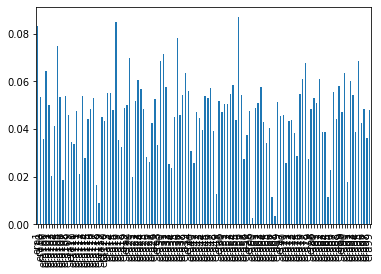


autocorrelation:  0.0942956429912995
mean correlation:  0.04511582114088417
sharpe:  2.749939487036395
smart sharpe:  2.493311215502231
2.493311215502231
---------------
iteration 7
worst eras:  ['era91', 'era89', 'era34', 'era116', 'era69', 'era107', 'era80', 'era56', 'era21', 'era114', 'era85', 'era81', 'era82', 'era87', 'era68', 'era62', 'era106', 'era54', 'era58', 'era113', 'era25', 'era41', 'era3', 'era47', 'era28', 'era117', 'era29', 'era103', 'era46', 'era9', 'era111', 'era4', 'era32', 'era99', 'era119', 'era59', 'era27', 'era11', 'era97', 'era19', 'era45', 'era53', 'era90', 'era112', 'era52', 'era40', 'era57', 'era51', 'era101', 'era88', 'era100', 'era73', 'era79', 'era65', 'era35', 'era42', 'era60', 'era102', 'era94', 'era84']

performance over time


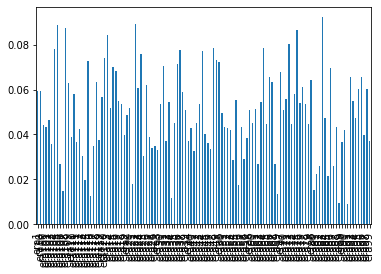


autocorrelation:  0.03848075431025086
mean correlation:  0.04918283804643806
sharpe:  2.5516963328060376
smart sharpe:  2.445857380920769
2.445857380920769
---------------
iteration 8
worst eras:  ['era118', 'era67', 'era86', 'era85', 'era49', 'era34', 'era75', 'era119', 'era68', 'era3', 'era74', 'era33', 'era66', 'era71', 'era22', 'era60', 'era21', 'era114', 'era26', 'era6', 'era12', 'era44', 'era107', 'era108', 'era96', 'era109', 'era17', 'era2', 'era100', 'era41', 'era120', 'era43', 'era83', 'era91', 'era79', 'era98', 'era27', 'era35', 'era48', 'era5', 'era115', 'era8', 'era94', 'era77', 'era61', 'era84', 'era14', 'era112', 'era55', 'era72', 'era76', 'era99', 'era24', 'era23', 'era28', 'era37', 'era97', 'era19', 'era110', 'era105']

performance over time


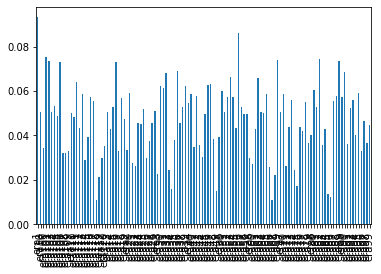


autocorrelation:  0.18684234052609935
mean correlation:  0.04666080713569059
sharpe:  2.851052861929137
smart sharpe:  2.353860864775115
2.353860864775115
---------------
iteration 9
worst eras:  ['era69', 'era58', 'era107', 'era68', 'era91', 'era89', 'era103', 'era106', 'era116', 'era62', 'era9', 'era81', 'era65', 'era82', 'era50', 'era87', 'era73', 'era32', 'era21', 'era56', 'era40', 'era59', 'era70', 'era60', 'era111', 'era113', 'era102', 'era41', 'era53', 'era46', 'era42', 'era114', 'era34', 'era80', 'era18', 'era112', 'era117', 'era11', 'era54', 'era27', 'era29', 'era110', 'era85', 'era57', 'era25', 'era104', 'era101', 'era39', 'era88', 'era47', 'era119', 'era93', 'era52', 'era45', 'era17', 'era33', 'era4', 'era79', 'era51', 'era1']

performance over time


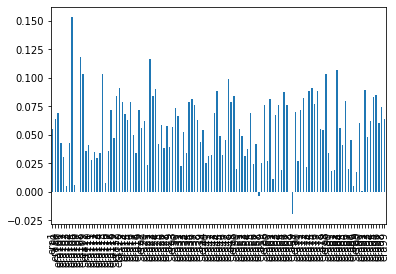


autocorrelation:  0.009556643998630649
mean correlation:  0.05439241328519033
sharpe:  1.8175268532374191
smart sharpe:  1.792865714794867
1.792865714794867
---------------
iteration 10
worst eras:  ['era3', 'era86', 'era118', 'era12', 'era67', 'era34', 'era66', 'era22', 'era75', 'era71', 'era105', 'era6', 'era74', 'era2', 'era108', 'era49', 'era85', 'era43', 'era114', 'era44', 'era100', 'era21', 'era26', 'era109', 'era35', 'era99', 'era84', 'era94', 'era115', 'era96', 'era83', 'era77', 'era8', 'era92', 'era120', 'era28', 'era48', 'era61', 'era78', 'era63', 'era97', 'era23', 'era19', 'era76', 'era7', 'era107', 'era55', 'era68', 'era72', 'era33', 'era98', 'era41', 'era14', 'era17', 'era91', 'era37', 'era119', 'era10', 'era81', 'era25']

performance over time


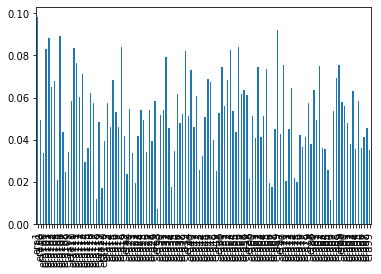


autocorrelation:  0.08819452834453577
mean correlation:  0.05028165147376749
sharpe:  2.5629469986864986
smart sharpe:  2.3379877872348254
2.3379877872348254
---------------
iteration 11
worst eras:  ['era69', 'era68', 'era58', 'era107', 'era103', 'era91', 'era62', 'era89', 'era106', 'era116', 'era60', 'era65', 'era50', 'era73', 'era87', 'era40', 'era9', 'era32', 'era70', 'era59', 'era111', 'era82', 'era112', 'era113', 'era56', 'era102', 'era53', 'era104', 'era46', 'era21', 'era42', 'era41', 'era11', 'era18', 'era110', 'era117', 'era54', 'era27', 'era57', 'era80', 'era101', 'era81', 'era52', 'era114', 'era39', 'era79', 'era88', 'era119', 'era29', 'era34', 'era85', 'era93', 'era47', 'era33', 'era15', 'era17', 'era1', 'era3', 'era51', 'era45']

performance over time


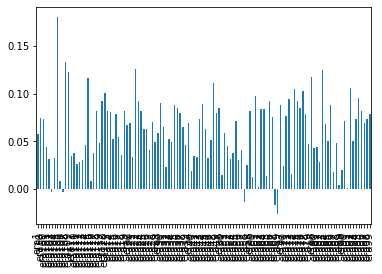


autocorrelation:  -0.021247818762731994
mean correlation:  0.05923930028290073
sharpe:  1.6881238717787892
smart sharpe:  1.716878052583859
1.716878052583859
---------------
iteration 12
worst eras:  ['era105', 'era86', 'era12', 'era118', 'era22', 'era75', 'era6', 'era2', 'era67', 'era74', 'era71', 'era66', 'era34', 'era108', 'era3', 'era43', 'era83', 'era8', 'era94', 'era49', 'era44', 'era115', 'era63', 'era109', 'era16', 'era84', 'era114', 'era100', 'era26', 'era77', 'era92', 'era23', 'era35', 'era48', 'era78', 'era28', 'era96', 'era61', 'era99', 'era76', 'era4', 'era72', 'era120', 'era25', 'era5', 'era85', 'era21', 'era19', 'era97', 'era98', 'era55', 'era64', 'era24', 'era13', 'era30', 'era37', 'era7', 'era90', 'era38', 'era17']

performance over time


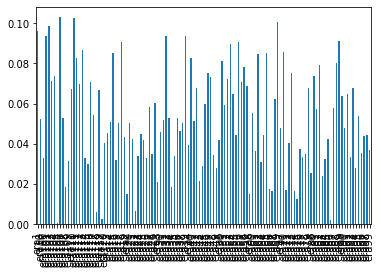


autocorrelation:  0.046811400105068506
mean correlation:  0.05205821190529416
sharpe:  2.0694367164655536
smart sharpe:  1.9672522940062025
1.9672522940062025
---------------
iteration 13
worst eras:  ['era68', 'era69', 'era58', 'era107', 'era91', 'era103', 'era62', 'era89', 'era60', 'era116', 'era106', 'era73', 'era50', 'era40', 'era65', 'era87', 'era9', 'era70', 'era32', 'era111', 'era113', 'era104', 'era112', 'era110', 'era102', 'era56', 'era41', 'era59', 'era11', 'era53', 'era46', 'era27', 'era54', 'era82', 'era117', 'era33', 'era42', 'era119', 'era18', 'era101', 'era21', 'era57', 'era15', 'era52', 'era79', 'era88', 'era93', 'era80', 'era39', 'era81', 'era29', 'era47', 'era1', 'era17', 'era85', 'era31', 'era51', 'era114', 'era34', 'era26']

performance over time


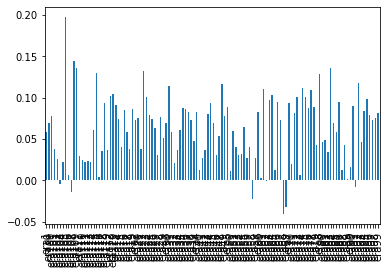


autocorrelation:  -0.026743322342474556
mean correlation:  0.060977311481214574
sharpe:  1.499868360642964
smart sharpe:  1.5337564919800566
1.5337564919800566
---------------
iteration 14
worst eras:  ['era86', 'era12', 'era2', 'era105', 'era75', 'era22', 'era71', 'era118', 'era3', 'era74', 'era66', 'era67', 'era34', 'era6', 'era108', 'era83', 'era43', 'era78', 'era16', 'era94', 'era44', 'era84', 'era28', 'era49', 'era63', 'era100', 'era115', 'era8', 'era109', 'era77', 'era92', 'era99', 'era72', 'era76', 'era35', 'era48', 'era4', 'era61', 'era23', 'era107', 'era114', 'era25', 'era96', 'era19', 'era13', 'era55', 'era98', 'era37', 'era10', 'era26', 'era5', 'era21', 'era97', 'era7', 'era120', 'era30', 'era45', 'era90', 'era64', 'era117']

performance over time


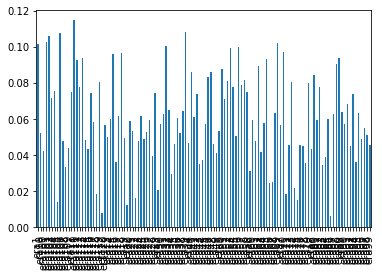


autocorrelation:  0.02881601147346822
mean correlation:  0.060199444513425834
sharpe:  2.436898954169284
smart sharpe:  2.3583414231176496
2.3583414231176496
---------------
iteration 15
worst eras:  ['era68', 'era69', 'era58', 'era107', 'era103', 'era91', 'era62', 'era60', 'era116', 'era89', 'era106', 'era73', 'era87', 'era9', 'era65', 'era40', 'era50', 'era32', 'era113', 'era104', 'era41', 'era70', 'era27', 'era112', 'era110', 'era111', 'era56', 'era53', 'era46', 'era33', 'era59', 'era102', 'era54', 'era11', 'era119', 'era15', 'era42', 'era101', 'era82', 'era18', 'era52', 'era57', 'era79', 'era88', 'era39', 'era93', 'era21', 'era85', 'era80', 'era81', 'era117', 'era17', 'era29', 'era31', 'era47', 'era1', 'era14', 'era24', 'era51', 'era34']

performance over time


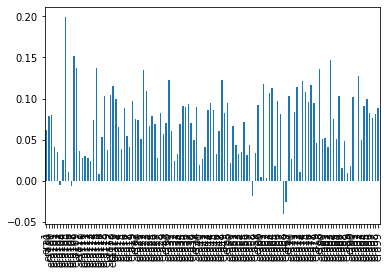


autocorrelation:  -0.04278563702841669
mean correlation:  0.06593469137171383
sharpe:  1.5871175354789329
smart sharpe:  1.6490346824034368
1.6490346824034368
---------------
iteration 16
worst eras:  ['era86', 'era105', 'era12', 'era22', 'era2', 'era118', 'era75', 'era3', 'era66', 'era71', 'era6', 'era74', 'era16', 'era83', 'era108', 'era78', 'era63', 'era49', 'era67', 'era43', 'era94', 'era114', 'era34', 'era115', 'era92', 'era72', 'era44', 'era76', 'era100', 'era109', 'era8', 'era25', 'era61', 'era96', 'era84', 'era99', 'era77', 'era23', 'era35', 'era28', 'era37', 'era19', 'era48', 'era98', 'era13', 'era5', 'era97', 'era4', 'era55', 'era26', 'era120', 'era10', 'era30', 'era45', 'era36', 'era20', 'era90', 'era64', 'era17', 'era95']

performance over time


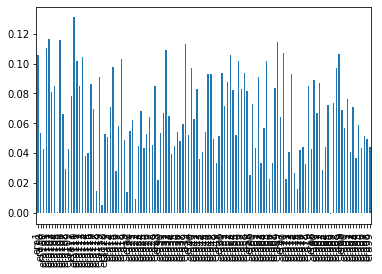


autocorrelation:  0.022126307942986506
mean correlation:  0.0631962930838057
sharpe:  2.18983456604227
smart sharpe:  2.133356297199484
2.133356297199484
---------------
iteration 17
worst eras:  ['era68', 'era69', 'era107', 'era58', 'era103', 'era91', 'era60', 'era62', 'era116', 'era87', 'era106', 'era73', 'era89', 'era9', 'era41', 'era40', 'era65', 'era104', 'era112', 'era113', 'era32', 'era27', 'era50', 'era70', 'era33', 'era110', 'era111', 'era46', 'era53', 'era15', 'era54', 'era102', 'era11', 'era56', 'era21', 'era119', 'era59', 'era42', 'era82', 'era18', 'era52', 'era117', 'era101', 'era88', 'era79', 'era85', 'era81', 'era57', 'era80', 'era93', 'era1', 'era39', 'era31', 'era24', 'era29', 'era14', 'era17', 'era26', 'era38', 'era47']

performance over time


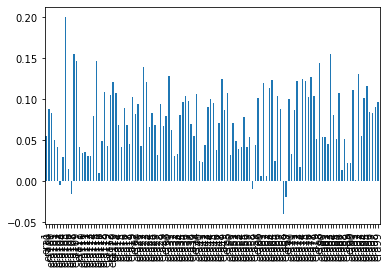


autocorrelation:  -0.042873769534036744
mean correlation:  0.0716648270390959
sharpe:  1.6700625549510706
smart sharpe:  1.735367516094995
1.735367516094995
---------------
iteration 18
worst eras:  ['era86', 'era105', 'era2', 'era12', 'era22', 'era66', 'era118', 'era71', 'era3', 'era75', 'era78', 'era74', 'era83', 'era16', 'era34', 'era6', 'era114', 'era108', 'era43', 'era28', 'era63', 'era67', 'era49', 'era72', 'era100', 'era77', 'era76', 'era94', 'era84', 'era4', 'era99', 'era25', 'era35', 'era8', 'era92', 'era115', 'era44', 'era55', 'era23', 'era96', 'era109', 'era19', 'era98', 'era37', 'era45', 'era30', 'era97', 'era61', 'era51', 'era10', 'era20', 'era120', 'era36', 'era7', 'era13', 'era90', 'era48', 'era5', 'era107', 'era27']

performance over time


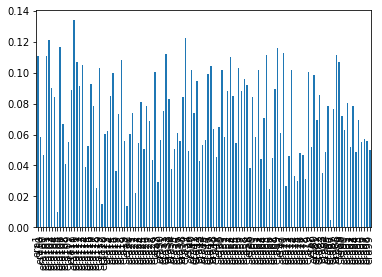


autocorrelation:  -0.03050761322399511
mean correlation:  0.07035097174652197
sharpe:  2.481897793683187
smart sharpe:  2.54747344727218
2.54747344727218


In [43]:
import matplotlib.pyplot as plt

def era_boost_train(X, y, era_col, proportion=0.5, epochs_per_step=10, num_iters=200):
    n_epochs = epochs_per_step
    features = X.columns
    train_model(model, X, y, n_epochs, batch_size)
    
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col

    for i in range(num_iters-1):
        print("---------------")
        print(f"iteration {i}")

        # score each era
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            # print(era_df.columns)
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])

        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print("worst eras: ", list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")

        print("")
        print("performance over time")
        plt.show()
        print("")

        # show performance
        print("autocorrelation: ", ar1(era_scores))
        print("mean correlation: ", np.mean(era_scores))
        print("sharpe: ", np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe: ", smart_sharpe(era_scores))

        print(smart_sharpe(era_scores))
        n_epochs += epochs_per_step
        train_model(model, worst_df[features], worst_df["target"], n_epochs, batch_size)

    return model

boost_model = era_boost_train(train_features, train_target, era_col=training_data["era"], proportion=0.5, epochs_per_step=1, num_iters=20)

In [44]:
# model.save('...h5')

Read tournament data

In [45]:
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.00,0.75,0.50,0.25,0.50,0.50,0.25,0.00,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.00,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.00,0.25,0.50,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.50,0.00,0.00,0.75,0.25,0.00,0.75,0.50,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.00,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.50,0.25,1.00,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.50,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.50,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00,1.00,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.50,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.50,0.00,0.00,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.00,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.00,0.00,0.00,0.50,0.75,1.00,0.75,0.00,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.00,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.00,0.50,0.50,0.25,0.25,0.50,0.50,1.00,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.00,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.50,0.50,0.00,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.00,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.00,0.0,0.25,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886706,nffad5892c45c8b1,eraX,live,0.75,0.50,0.50,0.50,1.00,0.50,0.50,0.25,0.25,0.25,0.75,1.00,0.50,0.00,0.00,0.75,0.50,0.25

Set validation data

In [46]:
validation_data = tournament_data[tournament_data['data_type'] == 'validation']
validation_data['era']

0          era121
1          era121
2          era121
3          era121
4          era121
            ...  
1545360    era212
1545361    era212
1545362    era212
1545363    era212
1545364    era212
Name: era, Length: 137779, dtype: object

In [47]:
del tournament_data
gc.collect()

20091

Predict

In [48]:
predictions = model.predict(validation_data[feature_names])
validation_data[PREDICTION_NAME] = predictions

In [49]:
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")

On validation the correlation has mean 0.024098027583332182 and std 0.03656674406798752


In [50]:
print("sharpe: ", sharpe(validation_correlations))
print("smart sharpe: ", smart_sharpe(validation_correlations))
print("sortino_ratio: ", sortino_ratio(validation_correlations))

sharpe:  0.6590148561908438
smart sharpe:  0.6554492576482689
sortino_ratio:  1.4785723873297398


Neutralize

In [51]:
from sklearn.preprocessing import MinMaxScaler
def _neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()
def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)
def normalize_and_neutralize(df, columns, by, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, proportion)
    return df[columns]

In [52]:
import scipy
validation_data["preds"] = predictions
validation_data["preds_neutralized"] = validation_data.groupby("era").apply(
    lambda x: normalize_and_neutralize(x, ["preds"], feature_names, 0.5) # neutralize by 50% within each era
)
scaler = MinMaxScaler()
validation_data["preds_neutralized"] = scaler.fit_transform(validation_data[["preds_neutralized"]]) # transform back to 0-1

In [ ]:
validation_data[PREDICTION_NAME] = validation_data['preds_neutralized']
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")

In [53]:
print("sharpe: ", sharpe(validation_correlations))
print("smart sharpe: ", smart_sharpe(validation_correlations))
print("sortino_ratio: ", sortino_ratio(validation_correlations))

sharpe:  0.6590148561908438
smart sharpe:  0.6554492576482689
sortino_ratio:  1.4785723873297398
